In [1]:
!pip install tensorflow

# FRUIT RECOGNISATION MODEL

In [46]:
import tensorflow as tf

In [3]:
from tensorflow.keras import models, layers

In [4]:
import matplotlib.pyplot as plt

In [5]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3

In [6]:
dataset= tf.keras.preprocessing.image_dataset_from_directory(
    "train",
    seed = 123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 1212 files belonging to 6 classes.


In [7]:
class_names = dataset.class_names
class_names

['freshapples',
 'freshbanana',
 'freshoranges',
 'rottenapples',
 'rottenbanana',
 'rottenoranges']

In [8]:
len(dataset)

38

In [9]:
38*32

1216

In [10]:
for image_batch,labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[3 3 0 1 5 0 3 4 3 5 4 5 5 0 1 3 1 1 1 4 0 1 5 2 2 2 4 1 1 3 0 5]


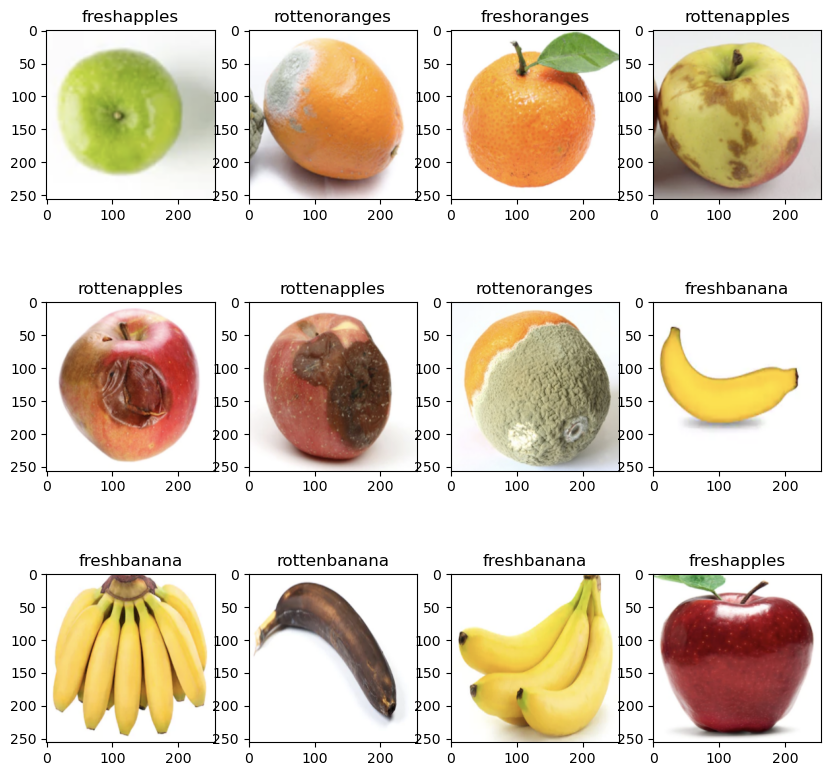

In [11]:
plt.figure(figsize=(10,10))
for image_batch,labels_batch in dataset.take(1):  
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])

In [12]:
def get_dataset(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000):
    assert(train_split+test_split+val_split)==1
    
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    train_size = int(train_split*ds_size)    
    val_size= int(val_split*ds_size)
    train_ds= ds.take(train_size)
    val_ds=ds.skip(train_size).take(val_size)
    test_ds= ds.skip(train_size).skip(val_size)
    return train_ds, val_ds, test_ds

In [13]:
train_ds, val_ds, test_ds = get_dataset(dataset)

In [14]:
len(train_ds)

30

In [15]:
len(val_ds)

3

In [16]:
len(test_ds)

5

# Shuffle

In [17]:
train_ds= train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
train_ds= test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
train_ds= val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

# Building The Model

In [47]:
resize_and_rescale= tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1./255)
])

# Data Augmentation

In [19]:
data_augmentation= tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

# Apply data augmentation on training data

In [20]:
train_ds = train_ds.map(
lambda x,y:(data_augmentation(x,training=True),y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

# Model

In [48]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes =6

model =models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32,kernel_size=(3,3),activation='relu',input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(n_classes, activation='softmax')
])
model.build(input_shape=input_shape)

In [22]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

# compilig the model 

In [49]:
model.compile(
 optimizer='adam',
 loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
 metrics=['accuracy']
)

In [70]:
history = model.fit(
  train_ds,
  batch_size=BATCH_SIZE,
  validation_data=val_ds,
  verbose=1,
  epochs=35,
)

Epoch 1/35
3/3 [==============================] - 23s 8s/step - loss: 1.7976 - accuracy: 0.1354 - val_loss: 1.7831 - val_accuracy: 0.2604
Epoch 2/35
3/3 [==============================] - 18s 7s/step - loss: 1.7734 - accuracy: 0.2917 - val_loss: 1.7533 - val_accuracy: 0.2604
Epoch 3/35
3/3 [==============================] - 19s 8s/step - loss: 1.7133 - accuracy: 0.3229 - val_loss: 1.6422 - val_accuracy: 0.3958
Epoch 4/35
3/3 [==============================] - 19s 7s/step - loss: 1.6400 - accuracy: 0.3958 - val_loss: 1.5948 - val_accuracy: 0.4062
Epoch 5/35
3/3 [==============================] - 21s 9s/step - loss: 1.5436 - accuracy: 0.3646 - val_loss: 1.5369 - val_accuracy: 0.3542
Epoch 6/35
3/3 [==============================] - 20s 8s/step - loss: 1.4134 - accuracy: 0.4479 - val_loss: 1.2465 - val_accuracy: 0.5625
Epoch 7/35
3/3 [==============================] - 20s 8s/step - loss: 1.3140 - accuracy: 0.5521 - val_loss: 1.2492 - val_accuracy: 0.5000
Epoch 8/35
3/3 [==================

In [71]:
scores=model.evaluate(test_ds)

5/5 [==============================] - 10s 718ms/step - loss: 1.3115 - accuracy: 0.5875


In [72]:
scores

[1.31154203414917, 0.5874999761581421]

In [73]:
history

In [74]:
history.params

{'verbose': 1, 'epochs': 35, 'steps': 3}

In [75]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [76]:
type(history.history['loss'])

list

In [77]:
len(history.history['loss'])

35

In [78]:
history.history['loss'][:5]

[1.7975797653198242,
 1.7734464406967163,
 1.7132869958877563,
 1.6400457620620728,
 1.543603777885437]

In [79]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

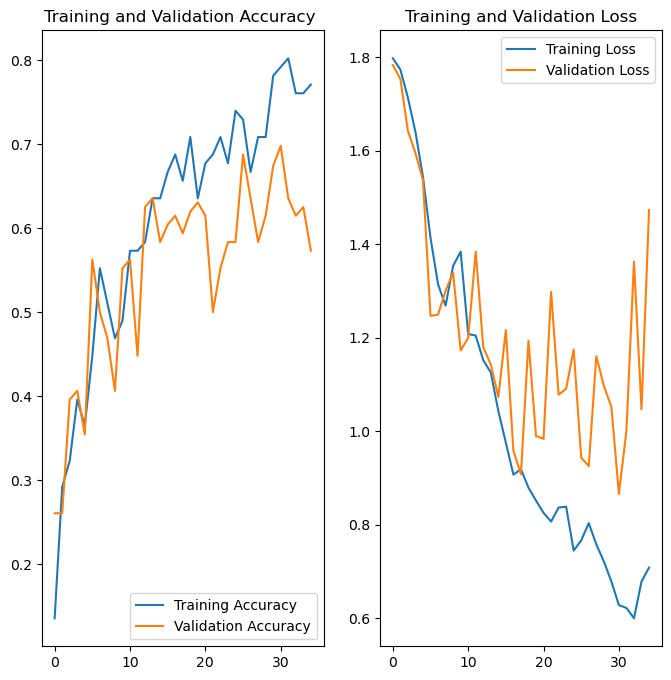

In [81]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(acc,label='Training Accuracy')
plt.plot(val_acc,label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy ')

plt.subplot(1,2,2)
plt.plot(loss,label='Training Loss')
plt.plot(val_loss,label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

First Image To Predict
actual label: freshbanana
1/1 [==============================] - 1s 858ms/step
predicted label: freshbanana


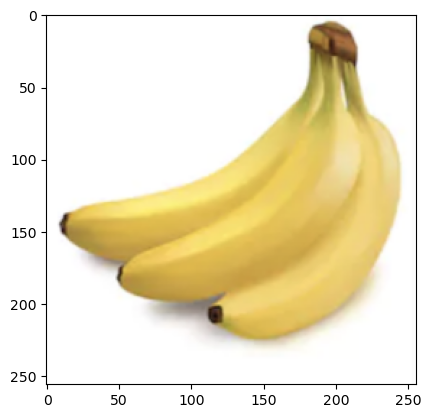

In [83]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("First Image To Predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [84]:
def predict(model,img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array,0)
    
    predictions = model.predict(img_array)
    
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence=round(100 * (np.max(predictions[0])),2)
    return predicted_class, confidence

# 

1/1 [==============================] - 0s 63ms/step


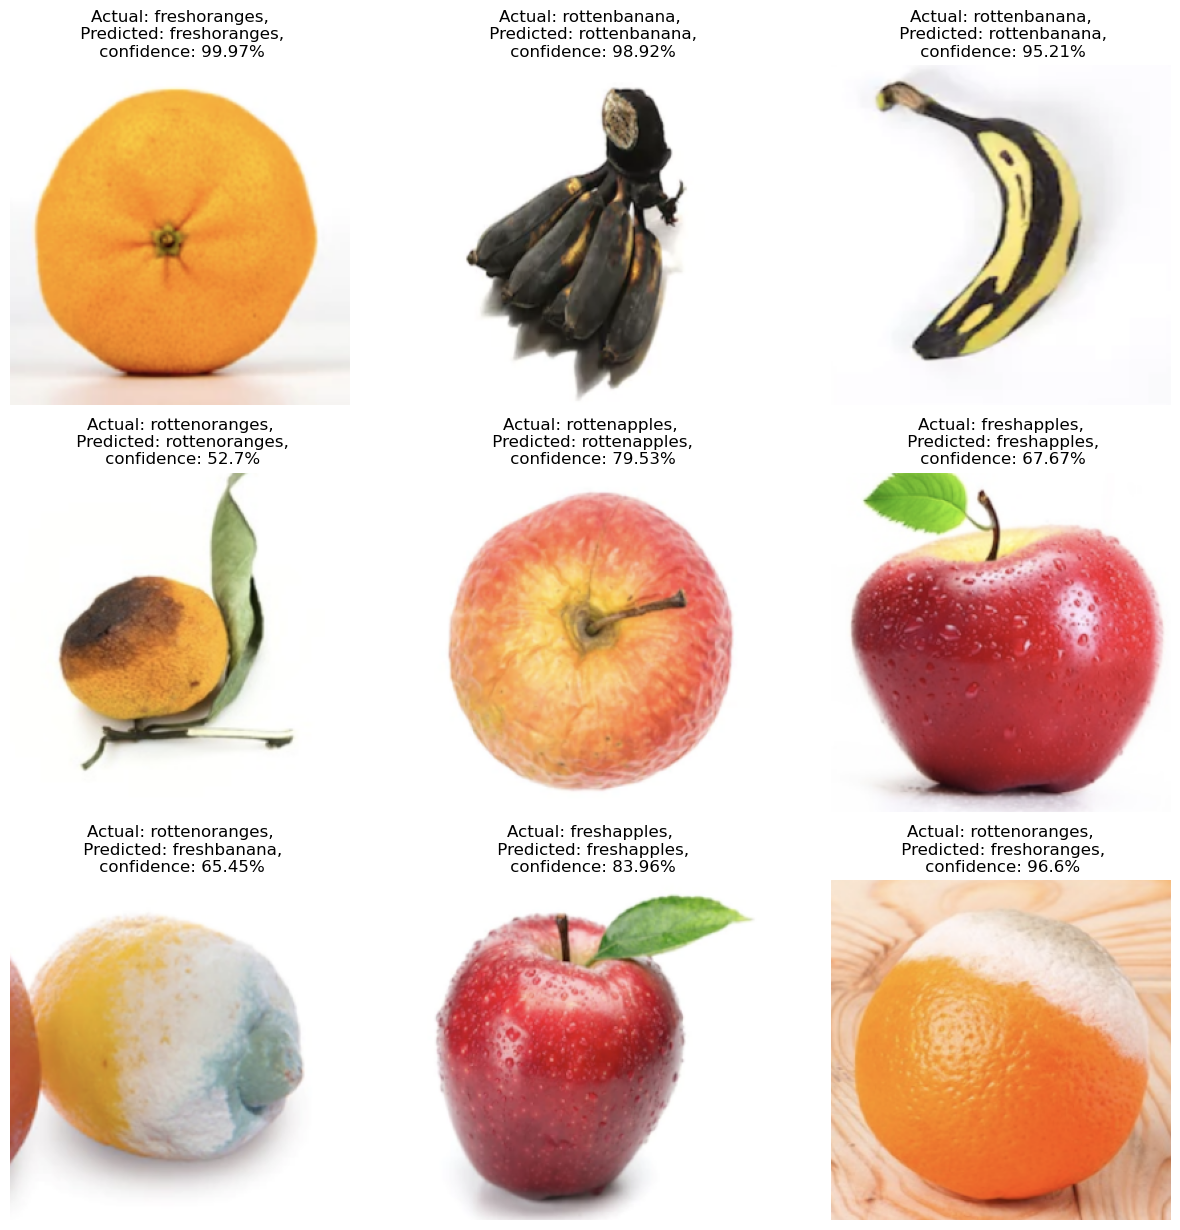

In [85]:
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax= plt.subplot( 3, 3,i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class,confidence = predict(model,images[i].numpy())
        actual_class=class_names[labels[i]]
        plt.title(f"Actual: {actual_class},\n Predicted: { predicted_class},\n confidence: {confidence}%")
        plt.axis("off")